In [ ]:
import sys
[sys.path.append(i) for i in ['.', '..']]
import torch
import numpy as np
from mirtorch.alg.cg import CG
from mirtorch.linear import Sense, FFTCn, Identity, Patch2D
from mirtorch.dic import soup, idct_basis_2d
import matplotlib.pyplot as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2

## Dictionary learning example

This example shows the usage of dictionary learning for mri reconstruction.
We try to minimize $\|Ax-y\|_2^2 + \lambda_1 \|Px - Y\|_2^2 + \lambda_2 \|Y\|_0$
Note that '0-norm' here is the number of all non-zeros across the whole matrix. 

### Load the dataset

kspace shape torch.Size([16, 320, 320])
image shape torch.Size([320, 320])


Text(0.5, 1.0, 'Undersampled')

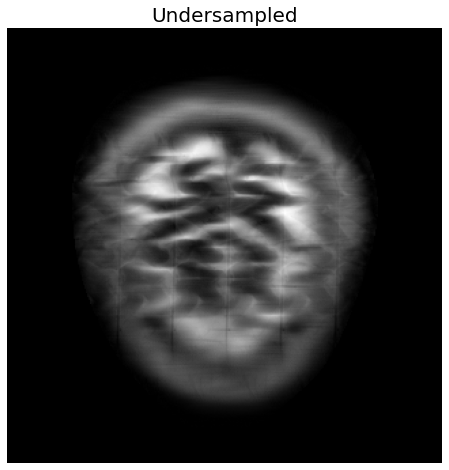

In [2]:
ex_multi = np.load('AXT2_210_6001736_layer11.npz')
device0 = torch.device('cpu')
# k-space
k_c = torch.tensor(ex_multi['k_r'] + 1j*ex_multi['k_i']).to(device0)/32767.0
# Sense map
s_c = torch.tensor(ex_multi['s_r'] + 1j*ex_multi['s_i']).to(device0)/32767.0
# Define Sense operator
(nc, nh, nw) = s_c.shape
Fop = FFTCn((nc, nh, nw), (nc, nh, nw), (1,2), norm = 'ortho')
# Conjugate phase reconstruction
I1 = (Fop.H*k_c).to(torch.complex64)
nx = 320
ny = 320
I1 = I1[:,nh//2-nx//2:nh//2+nx//2,nw//2-ny//2:nw//2+ny//2]
s_c = s_c[:,nh//2-nx//2:nh//2+nx//2,nw//2-ny//2:nw//2+ny//2].to(torch.complex64)
mask = torch.zeros(nx,ny)
mask[:,0:ny:8]=1
mask[:,150:170]=1
# mask = torch.ones(nx,ny)

Fop = FFTCn((nc, nx, ny), (nc, nx, ny), (1,2), norm = 'ortho')
K1 = Fop*I1
Sop = Sense(s_c, mask, batchmode = False)
I0 = Sop.H*K1
print('kspace shape', K1.shape)
print('image shape', I0.shape)

plt.figure(figsize=(8,8))
plt.imshow(torch.abs(I0).cpu().data.numpy(), cmap = 'gray')
plt.axis('off')
plt.title('Undersampled',size = 20)

### Initialize the dictionary

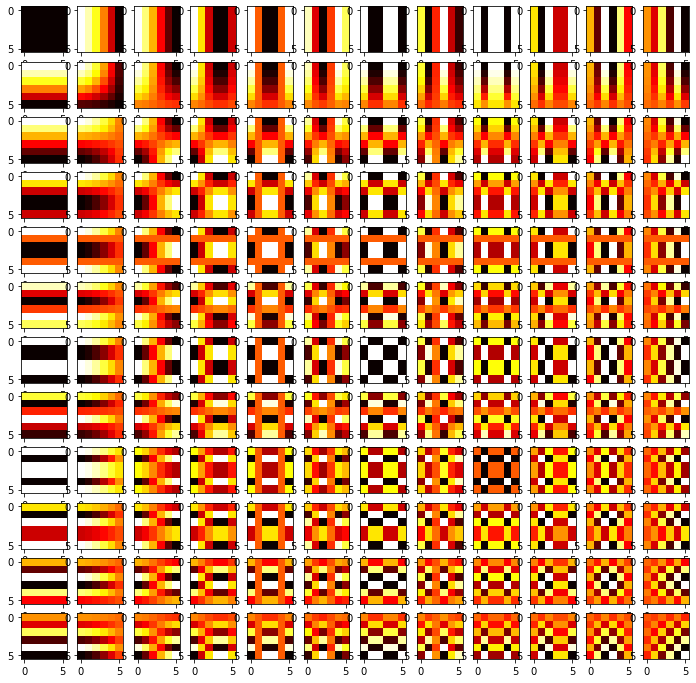

In [3]:
D0 = idct_basis_2d(36,144)
fig = plt.figure(figsize=(12,12))
columns = 12
rows = 12
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(D0[:,i-1].reshape([6,6]),cmap = 'hot')
plt.show()

### Optimization

In [4]:
num_outer = 20
num_inner = 5
lmbda = 1e-2
eta = 1e-3
size_kernel = 6
# Initialize the patch operator
Pop = Patch2D(size_in = [1,1,nx,ny],size_kernel = size_kernel, padded = True)
Px = Pop(I0.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).data.numpy()
# Initialize the dictionary
D = D0.astype(Px.dtype)
# Initialize the sparse code
X = sp.csr_matrix((D0.shape[1], Px.shape[1])).astype(Px.dtype)
# Initialize the CG solver
mult = (Pop.H*Pop*torch.ones([1,1,nx,ny])).squeeze(0).squeeze(0)
Id = Identity([nx,ny])
CG_DC = CG(Sop.H*Sop+eta*Id, max_iter = 20, alert=False, tol = 1e-10)
# rock 'n roll
for iouter in range(num_outer):
    [D, X, DX] = soup(Px, D, X, lmbda, num_inner)
    x = (Pop.H*torch.from_numpy(DX).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)/mult
    x = CG_DC.run(x, I0+eta*x)
    Px = Pop(x.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).data.numpy()

/home/guanhuaw/anaconda3/envs/torch/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Text(0.5, 1.0, 'Reconstruction: DL')

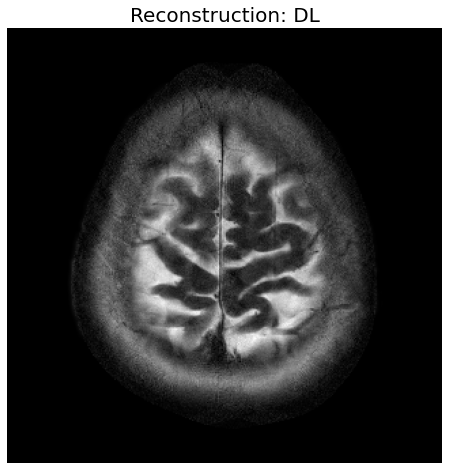

In [5]:
plt.figure(figsize=(8,8))
plt.imshow(np.abs(torch.flip(x,[0,1])), cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('Reconstruction: DL',size = 20)

### See the (blindly) learned dictionary

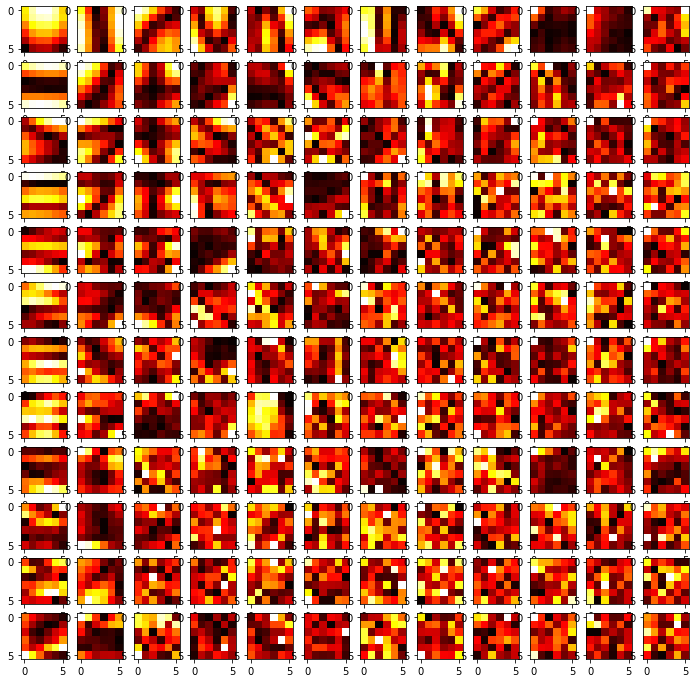

In [6]:
fig = plt.figure(figsize=(12,12))
columns = 12
rows = 12
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.abs(D[:,i-1]).reshape([6,6]),cmap = 'hot')
plt.show()